In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# ===================== 1. Load & Preprocess ======================
# Load data
df = pd.read_excel("Online Retail.xlsx")
df.info()
# Ambil subset berguna: contoh analisis customer berdasarkan total pembelian
df = df[df['Quantity'] > 0]
df = df.dropna(subset=['CustomerID'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [3]:
# Hitung total pembelian per pelanggan
customer_df = df.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',
    'Quantity': 'sum',
    'UnitPrice': 'mean',
    'InvoiceDate': ['min', 'max']
})
customer_df.columns = ['InvoiceCount', 'TotalQuantity', 'AvgUnitPrice', 'FirstPurchase', 'LastPurchase']
customer_df['Recency'] = (df['InvoiceDate'].max() - customer_df['LastPurchase']).dt.days
features = customer_df[['InvoiceCount', 'TotalQuantity', 'AvgUnitPrice', 'Recency']]

In [4]:
# ===================== 2. Feature Scaling ======================
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


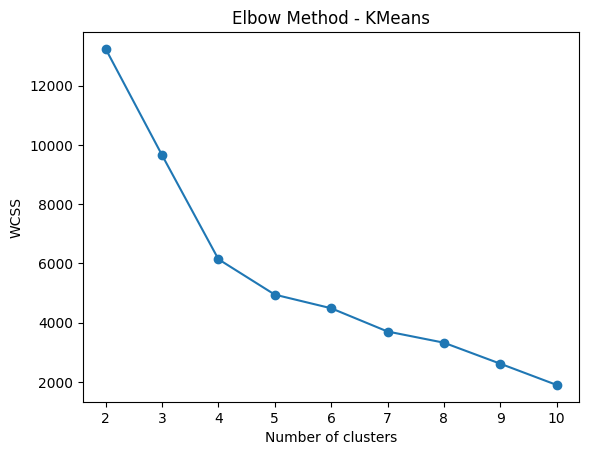

In [5]:
# ===================== 3. Elbow Method (KMeans) ======================
wcss = []
K_range = range(2, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_features)
    wcss.append(km.inertia_)  # Inertia = total WCSS

plt.plot(K_range, wcss, marker='o')
plt.title('Elbow Method - KMeans')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [6]:
# ===================== 4. Evaluation Metrics Function ======================
def evaluate_clustering(X, labels):
    silhouette = silhouette_score(X, labels)
    calinski = calinski_harabasz_score(X, labels)
    davies = davies_bouldin_score(X, labels)
    dunn = dunn_index(X, labels)
    return silhouette, calinski, davies, dunn

In [7]:
# =============== 5. Dunn Index Manual Implementation =================
def dunn_index(X, labels):
    distances = squareform(pdist(X))
    unique_clusters = np.unique(labels)
    intra_dists = []
    inter_dists = []

    for i in unique_clusters:
        cluster_i = np.where(labels == i)[0]
        intra = np.max([distances[a, b] for a in cluster_i for b in cluster_i if a != b] or [0])
        intra_dists.append(intra)
        for j in unique_clusters:
            if i < j:
                cluster_j = np.where(labels == j)[0]
                inter = np.min([distances[a, b] for a in cluster_i for b in cluster_j])
                inter_dists.append(inter)

    return min(inter_dists) / max(intra_dists)


In [8]:
# ===================== 6. Apply Clustering & Evaluate ======================
models = {
    "KMeans": KMeans(n_clusters=4, random_state=42),
    "Agglomerative": AgglomerativeClustering(n_clusters=4)
}

results = {}

for name, model in models.items():
    labels = model.fit_predict(scaled_features)
    silhouette, calinski, davies, dunn = evaluate_clustering(scaled_features, labels)
    results[name] = {
        'Silhouette': silhouette,
        'Calinski-Harabasz': calinski,
        'Davies-Bouldin': davies,
        'Dunn': dunn
    }

In [9]:
# ===================== 7. Print Hasil Evaluasi ======================
result_df = pd.DataFrame(results).T
print(result_df)

               Silhouette  Calinski-Harabasz  Davies-Bouldin      Dunn
KMeans           0.582579        2638.391491        0.515802  0.000619
Agglomerative    0.528085        2185.283839        0.553595  0.001007


## 📐 Penjelasan Matematis Metrik Evaluasi Clustering

### 1. **Silhouette Coefficient**
Silhouette coefficient mengukur seberapa mirip sebuah titik dengan klusternya sendiri dibandingkan dengan kluster lain.

$$
s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}
$$

**Keterangan:**
- $a(i)$ = Rata-rata jarak dari titik $i$ ke semua titik lain dalam klusternya sendiri
- $b(i)$ = Rata-rata jarak dari titik $i$ ke titik-titik di kluster terdekat lainnya
- Nilai $s(i)$ berada di antara -1 dan 1:
  - $s(i) \approx 1$: Titik berada di kluster yang tepat
  - $s(i) \approx 0$: Titik di antara dua kluster
  - $s(i) \approx -1$: Titik salah tempat (mis-clustered)

---

### 2. **Calinski-Harabasz Index (Variance Ratio Criterion)**
Metrik ini membandingkan sebaran antar kluster dan dalam kluster.

$$
CH = \frac{\text{Tr}(B_k)}{\text{Tr}(W_k)} \cdot \frac{n - k}{k - 1}
$$

**Keterangan:**
- $B_k$ = Matriks dispersi antar kluster
- $W_k$ = Matriks dispersi dalam kluster
- $n$ = Jumlah total data
- $k$ = Jumlah kluster
- Semakin besar nilai $CH$, semakin baik pemisahan kluster

---

### 3. **Davies-Bouldin Index**
Mengukur rata-rata kemiripan antar kluster (rasio antara jarak dalam kluster dan antar kluster).

$$
DB = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} \left( \frac{\sigma_i + \sigma_j}{d_{ij}} \right)
$$

**Keterangan:**
- $\sigma_i$ = Rata-rata jarak dari titik-titik dalam kluster $i$ ke centroid-nya
- $d_{ij}$ = Jarak antara centroid kluster $i$ dan $j$
- Nilai yang lebih kecil menunjukkan kluster yang lebih baik (lebih kompak dan saling terpisah)

---

### 4. **Dunn Index**
Mengukur rasio antara jarak minimum antar kluster dengan jarak maksimum dalam kluster.

$$
D = \frac{\min_{1 \leq i < j \leq k} d(c_i, c_j)}{\max_{1 \leq l \leq k} \delta(C_l)}
$$

**Keterangan:**
- $d(c_i, c_j)$ = Jarak minimum antara dua kluster berbeda
- $\delta(C_l)$ = Diameter (jarak maksimum antar titik) dalam kluster $l$
- Semakin tinggi nilai Dunn Index, semakin baik pemisahan dan kekompakan kluster

---

### 📌 Kesimpulan:
| Metrik              | Interpretasi                     |
|---------------------|----------------------------------|
| **Silhouette**       | Semakin tinggi, semakin baik     |
| **Calinski-Harabasz**| Semakin tinggi, semakin baik     |
| **Davies-Bouldin**   | Semakin rendah, semakin baik     |
| **Dunn Index**       | Semakin tinggi, semakin baik     |


## ✅ Kesimpulan Evaluasi Model Clustering

Berikut hasil evaluasi menggunakan empat metrik evaluasi clustering:

| Metrik              | KMeans        | Agglomerative | Interpretasi                                               |
|---------------------|---------------|----------------|-------------------------------------------------------------|
| **Silhouette**       | **0.5826**     | 0.5281         | KMeans lebih baik, karena nilai lebih tinggi               |
| **Calinski-Harabasz**| **2638.39**    | 2185.28        | KMeans lebih baik, menunjukkan kluster lebih terpisah      |
| **Davies-Bouldin**   | **0.5158**     | 0.5536         | KMeans lebih baik, karena nilai lebih rendah               |
| **Dunn Index**       | 0.000619      | **0.001007**   | Agglomerative lebih baik, karena nilai lebih tinggi        |

### 🔍 Analisis:
- **KMeans** unggul dalam 3 dari 4 metrik utama: *Silhouette*, *Calinski-Harabasz*, dan *Davies-Bouldin*.
- **Agglomerative Clustering** hanya unggul di **Dunn Index**, yang menunjukkan sedikit keunggulan dalam rasio pemisahan kluster terhadap kekompakan.

### 🏆 Kesimpulan Akhir:
Secara keseluruhan, **KMeans merupakan metode clustering yang lebih optimal untuk dataset ini**, karena menghasilkan kluster yang lebih kompak, lebih terpisah, dan dengan performa yang lebih konsisten di berbagai metrik evaluasi utama.
